# CNN for Image Classification (CIFAR-10): Data Augmentation and Dropout Layers

In this exercise we are going to implement and train a convolutional neural network (CNN) for classifying images in the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set using two regularisation techniques: data agumentation and dropout layers.

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

In [2]:
from torchvision import datasets
import torchvision.transforms.v2 as transforms

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/ml2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/apps/daint/UES/6.0.UP04/sandboxes/sarafael/ml2024/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
import numpy as np
from tqdm import trange

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

## Data Set

### Loading the Data Set

**Note**: in constrast to the previous notebook, here we loaded `transforms.v2`, the new version of `transforms`. See [V1 or V2? Which one should I use?](https://pytorch.org/vision/stable/transforms.html#v1-or-v2-which-one-should-i-use) for examples and a short explanation of the difference.  You can try out V2, or stick with V1. For this exercise, both are equivalent. If you decide to use V1 as in the previous notebook, change the above import `import torchvision.transforms.v2 as transforms` to `from torchvision import transforms` (and re-run the cell).

The data in [`torchvision`](https://pytorch.org/vision/stable/index.html) data sets consists of [PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html) images with values in the interval $[0, 1]$. In order to use the images for training, they need to be converted to PyTorch tensors ([`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html)). It is also good practice to normalise the images on the interval $[-1, 1]$ to reduce data skewness.

However, we want to perform data augmentation on our data set, in order to reduce overfitting. In addition to the `ToImage` and `Normalize` transformations we already used, `torchvision.transforms` contains many more transformation for data augmentation.

*Define a transformation, using [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended), converting PIL images to PyTorch tensors and normalising them (with mean and standard deviation of `0.5` for each channel). Additionally, apply the following data agumentation transformations:*
* _Random horizontal flip_
* _Random affine transformation (rotation + translation)_
    * _10 degrees rotation maximum_
    * _0.1 translation maximum (in each direction)_

In [6]:
transform_augmentation = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)), # Random rotation
    # scale=True re-scale according to dtype
    # integer dtype: [0, 255]
    # float dtype: [0, 1]
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalise images: out = (in - mean) / std
])

Using the transformation defined above, we can define and download the training set:

In [7]:
augtrainset = datasets.CIFAR10("data/", download=True, train=True, transform=transform_augmentation)

Files already downloaded and verified


The test set does not need data augmentation. We also want to define a training set without data agumentation for comparison.

*Define a transformation, using [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended), converting PIL images to PyTorch tensors and normalising them (with mean and standard deviation of `0.5` for each channel).

In [8]:
transform = transforms.Compose([
    transforms.ToImage(), # Convert PIL image to tensor
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalise images: out = (in - mean) / std
])

In [9]:
trainset = datasets.CIFAR10("data/", download=True, train=True, transform=transform)
testset = datasets.CIFAR10("data/", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


*Use [scikit-learn](https://scikit-learn.org/stable/)'s `train_test_split` to define which images (i.e. which indices) of the training set are used for training and which are used for validation, using random sampling. Use 20% of training data for the validation set.*

In [10]:
n = len(trainset)

# TODO
idx_train, idx_valid = train_test_split(np.arange(n), test_size=0.2, random_state=42)

Given the indices of the training and validation sets obtained above, it is possible to define PyTorch random data samplers as follows:

In [11]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_valid)

Define a data loader (using a data set and a sampler) for the augmented and non-aurgmented training sets, as well as the validation set:

In [12]:
augtrainloader = torch.utils.data.DataLoader(augtrainset, batch_size=64, sampler=train_sampler, drop_last=True, num_workers=2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, drop_last=True, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler, drop_last=True, num_workers=2)

Here we chose a batch size of `64`. The batch size can have a big impact on training and therefore it is an hyperparameter of the model. We drop the last batch so that all batches have the same size, for simplicity. For the test set, we just load the examples in sequence, with the same batch size

In [13]:
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True, num_workers=2)

Finally, we can define iterators to iterate over `trainloader`, `trainloader_aug`, `validloader` and `testloader` batches:

In [14]:
augtrainiter = iter(augtrainloader)
trainiter = iter(trainloader)
validiter = iter(validloader)
testiter = iter(testloader)

### Visualizing the Data

It is always good practice to look at the data.

In [15]:
label_to_name = { 
    i : name 
    for i, name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]) 
}

*Get a batch of images with data augmentation and visualize them.*

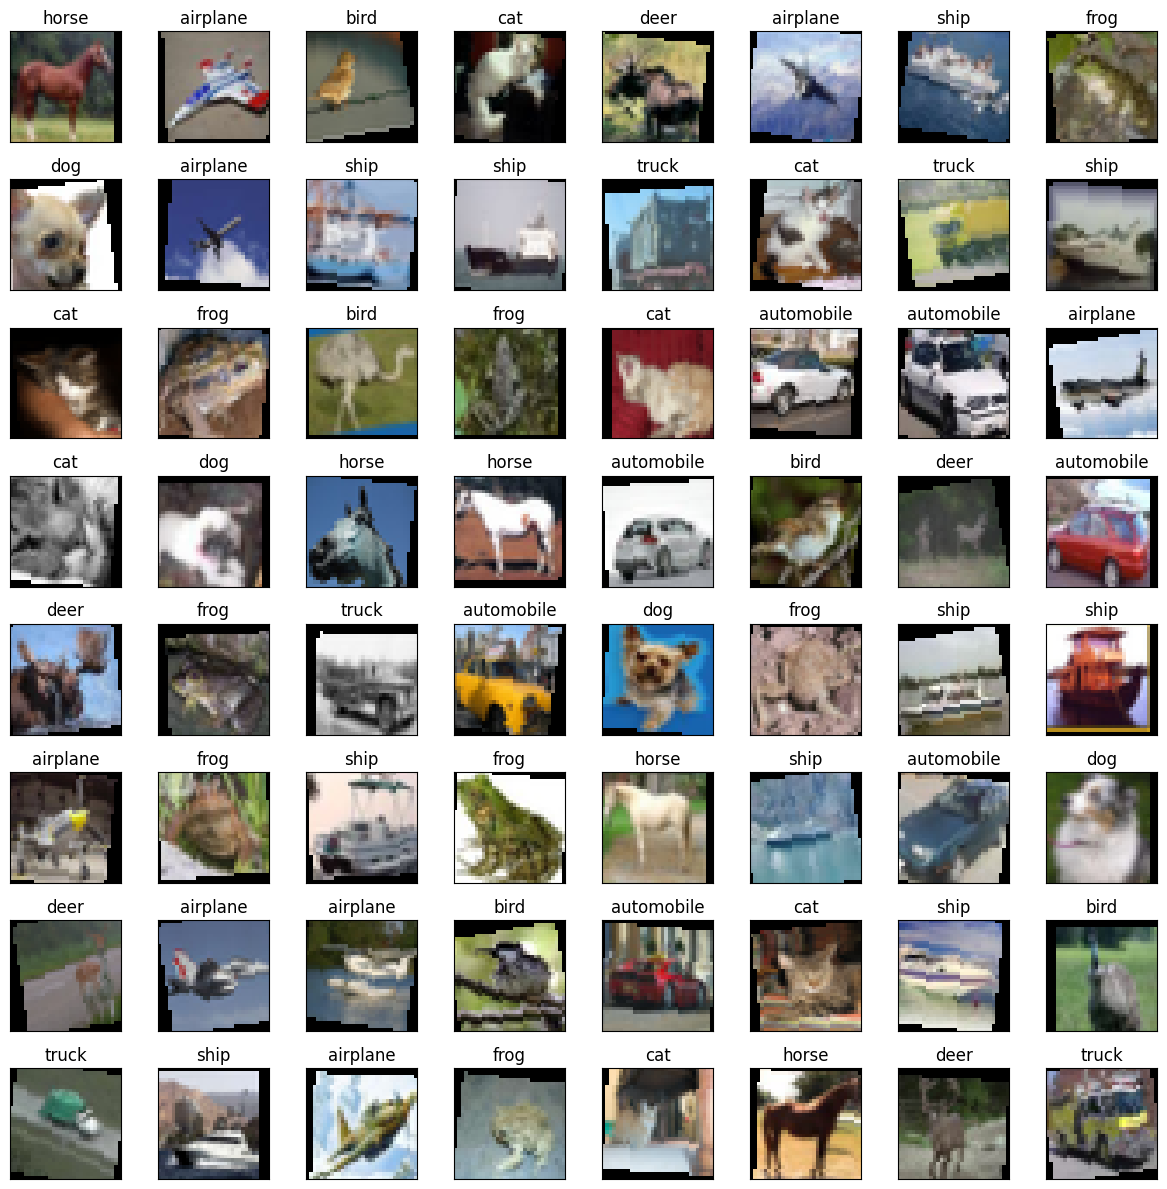

In [16]:
# TODO
images, labels = next(augtrainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze() * 0.5 + 0.5 

    # Transpose image from C x H x W to H x W x C
    img = np.transpose(img, (1, 2, 0))
    
    # Plot image
    plt.imshow(img)
    
    # Get name
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

We can see that rotations and translations are indeed applied to the images used for training.However, this introduced empty pixels. If we had bigger images, we could have cropped them after the affine transformation.

## Convolutional Neural Network with Dropout Layers

*Define a simple convolutional neural network with the following characteristics:*
* _Three convolutional layers with `16`, `32`, and `64` channels with $3 \times 3$ kernels_
* _Maximum pooling with $2 \times 2$ kernel_
* _Two fully connected layers for classification_
* _Rectified linear unit (ReLU) activation function (after each convolutional layer and after the first fully connected layer_
* _Dropout layers with probability $p$ (defined as input of the model constructor), before the first and second linear layers_

*Decide if you want to add a `LogSoftmax` layer (or, equivalently, `F.log_softmax`) at the end of the network or not. You'll have to adjust the loss function accordingly.*

*Choose appropriate values for padding, and for the input and output size of the fully connected layers. You can consider that the hard-coded batch size of `64` defined above does not change.*

*To simplify the `forward()` function compared to the previous notebook, you can define the convolutional part and the fully connected part as `nn.Sequential` (sub-)modules.*

In [17]:
class CNN(nn.Module):
    def __init__(self, dropoutp=0.0):
        super().__init__()

        self.conv = nn.Sequential(
            # TODO
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            # TODO
            nn.Dropout(dropoutp),
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropoutp),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):

        # Input shape
        assert x.shape == (64, 3, 32, 32)

        # Apply convolutional layers
        # TODO
        x = self.conv(x)

        # Flatten features for fully connected layers
        # TODO
        x = x.view(-1, 64 * 4 * 4)

        assert x.shape == (64, 64 * 4 * 4)

        # Apply fully connected layers
        # TODO
        x = self.fc(x)

        assert x.shape == (64, 10)

        return x

### Training and Inference on GPUs

Using a graphical processing unit (GPU) can speed up training by several orders of magnitude. In PyTorch, it is very easy to take advantage of GPUs. We can define a `torch.device`, depending on the resources that are available:

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Training

*Implement the missing bits in  training loop (identified by comments):*
* _Move data (images and labels) from the CPU to the `device`_
* _Reset gradients of the optimizer_
* _Perform forward pass_
* _Compute the loss (tip: `torch.Tensor.item()` allows to get the element of a single-element tensor)_
* _Perform bakcpropagation_
* _Update the weights of the model using the optimizer_

Some layers, such as `Dropout` and `BatchNorm2D` change behaviour from training to inference, and it is therefore very important to use `train()` and `eval()` member functions of `torch.nn.Model` to activate the correct behaviour.

In [19]:
def train(model, optimizer, loss_function, trainloader, epochs, device):
    import time
    from copy import deepcopy

    # Move model to the device
    # TODO
    model.to(device)

    train_losses, valid_losses, accuracies = [], [], []
    
    best_valid_loss = np.inf

    pbar = trange(epochs, desc='Training', leave=True)
    for epoch in pbar:
        
        epoch_loss = 0

        # Ensure model is in training mode
        # TODO
        model.train()
        
        for images, labels in trainloader:

            # Move data to GPU
            # TODO
            images, labels = images.to(device), labels.to(device)
        
            # Initialize optimizer gradients to zero
            # TODO
            optimizer.zero_grad()
            
            # Perform forward pass
            # TODO
            output = model(images)
            
            # Compute the loss
            # TODO
            loss = loss_function(output, labels)
            
            # Perform backpropagation
            # TODO
            loss.backward()
            
            # Update model weights
            # TODO
            optimizer.step()
            
            epoch_loss += loss.item()
            
        valid_loss = 0
        accuracy = 0

        with torch.no_grad():

            # Ensure model is in evaluation mode
            # TODO
            model.eval()

            for images, labels in validloader:

                # Move data to GPU
                # TODO
                images, labels = images.to(device), labels.to(device)
                    
                # Perform forward pass
                # TODO
                output = model(images)
                    
                # Accumulate validation loss
                valid_loss += loss_function(output, labels).item()
                
                # Compute class probabilities
                # TODO
                p = torch.exp(output)
                    
                # Compute accuracy
                top_p, top_c = p.topk(1, dim=1) # Top prediction
                equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)
                accuracy += torch.mean(equals)
                    
        train_losses.append(epoch_loss/len(trainloader))
        valid_losses.append(valid_loss/len(validloader))
        accuracies.append(accuracy.item()/len(validloader)*100)

        # Save best model state dictionary
        # Hint: remember to perform a deep copy
        # TODO
        if valid_losses[-1] < best_valid_loss:
            best_state_dict = deepcopy(model.state_dict())
            best_valid_loss = valid_losses[-1]
                
        pbar.set_postfix({"Accuracy": accuracies[-1]})

    # Re-Load best model at the end of training
    # TODO
    model.load_state_dict(best_state_dict)
    
    return train_losses, valid_losses, accuracies

*Define the appropriate loss function, depending on your model output:*

In [20]:
# TODO
nll_loss = nn.NLLLoss()

For optimization, we will use the `Adam` optimizer with the following learning rate:

In [21]:
learning_rate = 0.001

*Define and train three models:*
* _Without data augmentation and with dropout layers (`15` epochs)_
* _With dropout layers (dropout probability of `0.5`) and without data augmentation (`30` epochs)_
* _With data agumentation and without dropout layers (`30` epochs)_

*Do not forget to define the corresponding `Adam` optimizer for each model (with the same `learning_rate`).*

_Without data augmentation and with dropout layers (`15` epochs):_

In [22]:
# TODO
model = CNN()

# TODO
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# TODO
train_losses, valid_losses, accuracies = train(model, optimizer, nll_loss, trainloader, epochs=15, device=device)

Training: 100%|██████████| 15/15 [02:39<00:00, 10.67s/it, Accuracy=71.1]


* _With dropout layers (dropout probability of `0.5`) and without data augmentation (`30` epochs):_

In [23]:
# TODO
dmodel = CNN(dropoutp=0.5)

# TODO
doptimizer = optim.Adam(dmodel.parameters(), lr=learning_rate)

# TODO
d_train_losses, d_valid_losses, d_accuracies = train(dmodel, doptimizer, nll_loss, trainloader, epochs=30, device=device)

Training: 100%|██████████| 30/30 [04:49<00:00,  9.64s/it, Accuracy=76.3]


* _With data agumentation and without dropout layers (`30` epochs):_

In [24]:
# TODO
amodel = CNN()

# TODO
aoptimizer = optim.Adam(amodel.parameters(), lr=learning_rate)

# TODO
a_train_losses, a_valid_losses, a_accuracies = train(amodel, aoptimizer, nll_loss, augtrainloader, epochs=30, device=device)

Training: 100%|██████████| 30/30 [10:46<00:00, 21.53s/it, Accuracy=79.3]


Once training is finished we can plot the loss of both the training and the validation sets as a function of the epoch:

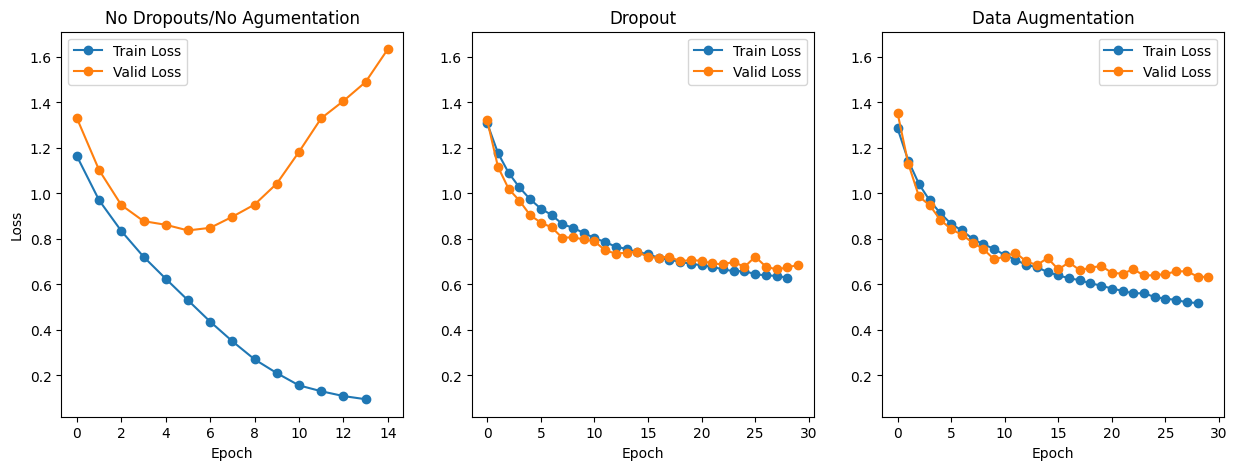

In [25]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(train_losses[1:], "o-", label="Train Loss")
ax1.plot(valid_losses, "o-", label="Valid Loss")
ax1.set_title("No Dropouts/No Agumentation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
ax2.plot(d_train_losses[1:], "o-", label="Train Loss")
ax2.plot(d_valid_losses, "o-", label="Valid Loss")
ax2.set_title("Dropout")
ax2.set_xlabel("Epoch")
ax2.legend()
ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)
ax3.plot(a_train_losses[1:], "o-", label="Train Loss")
ax3.plot(a_valid_losses, "o-", label="Valid Loss")
ax3.set_title("Data Augmentation")
ax3.set_xlabel("Epoch")
ax3.legend()
plt.show()

We notice immediately that regularisation reduces overfitting, and the validation loss does not start increasing early as without regulasiation. This means that the model is not over-fitting the training set, can be trained for longer, and generalises better. We can see that dropout layers and data agumentation have a similar effect on training.

## Evaluation of Trained Model

*Complete the missing steps needed to obtained the predicted labels and the ground truth for the whole of the test set.*

In [26]:
def predict(model, testloader):
    n = len(testloader) * 64
    
    y_pred = np.zeros(n)
    y_true =np.zeros(n)
    
    i = 0
    
    # Ensure model is in evaluation mode
    # TODO
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:

            # Move data to GPU
            # TODO
            images, labels = images.to(device), labels.to(device)
                
            # Perform forward pass
            # TODO
            output = model(images)
                
            # Compute class probabilities
            # TODO
            p = torch.exp(output)
                
            # Get class of top prediction
            # TODO
            p, c = torch.max(p, dim=1) 
            
            y_pred[i*64:i*64+64] = c.cpu().numpy()
            y_true[i*64:i*64+64] = labels.cpu().numpy()
            
            i += 1
            
    assert i == len(testloader)
    
    return y_pred, y_true

In [27]:
l_pred, l_true = predict(model, testloader)
a_l_pred, a_l_true = predict(amodel, testloader)
d_l_pred, d_l_true = predict(dmodel, testloader)

### Accuracy

In [28]:
metrics.accuracy_score(l_pred, l_true)

0.7024238782051282

In [29]:
metrics.accuracy_score(a_l_pred, a_l_true)

0.7875600961538461

In [30]:
metrics.accuracy_score(d_l_pred, d_l_true)

0.7633213141025641

*If there is time left, you can try to improve the model (make the model deeper, replace dropout layers with batch normalization, ...) in order to improve performance.*